In [1]:
cd /home

/home


# Results experiments

###### by Cristobal Donoso-Oliva et.al., 2022

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd
import numpy as np
import tomli
import os 

from src.pipeline.base import load_pt_data, compile_astromer
from src.models.zero import get_ASTROMER
from src.utils import get_metrics

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# plt.style.use('dark_background')|

In [3]:
def collect_metrics(config_files_folder, step='classification', cases=['a', 'b']):
    '''
    Concatenate dataframes containing testing/validation metrics.'
    '''
    metrics_list = []
    for sci_case in cases:
        for file in os.listdir(config_files_folder):
            if sci_case != file.split('.')[3]:
                continue
            fold_n = file.split('.')[2].split('f')[-1]
            ft_data = file.split('.')[0]

            current = os.path.join(config_files_folder, file)
            with open(current, mode="rb") as fp:
                config = tomli.load(fp)

            if step == 'pretraining':
                metrics = pd.read_csv(os.path.join(config[step]['exp_path'], 'metrics.csv'))
                return metrics
            try:
                metrics = pd.read_csv(os.path.join(config[step]['exp_path'], 'metrics.csv'))
                metrics['ft_data']  = [ft_data]*metrics.shape[0]
                metrics['fold'] = [fold_n]*metrics.shape[0]
                metrics['file']  = [file]*metrics.shape[0]
                metrics['case']  = [sci_case]*metrics.shape[0]
                metrics_list.append(metrics)

            except Exception as e:
                continue
    return pd.concat(metrics_list)

## Pretraining results

First we take an arbitrary config file from the `experiments_config_files` folder

In [4]:
experiments_config_files = './presentation/experiments/astromer_0/config_files/macho/'

We open the config file to see the used pretraining weights

In [5]:
with open(os.path.join(experiments_config_files,
                       os.listdir(experiments_config_files)[0]), mode="rb") as fp:
    config = tomli.load(fp)
config['finetuning']['weights']

'./presentation/experiments/astromer_0/results/macho/pretraining'

In [6]:
metrics = collect_metrics(experiments_config_files, step='pretraining')

In [7]:
loss = metrics['rmse'].values[0]
r2 = metrics['r_square'].values[0]

In [8]:
config['finetuning']['weights'], loss

('./presentation/experiments/astromer_0/results/macho/pretraining',
 0.1492867320775985)

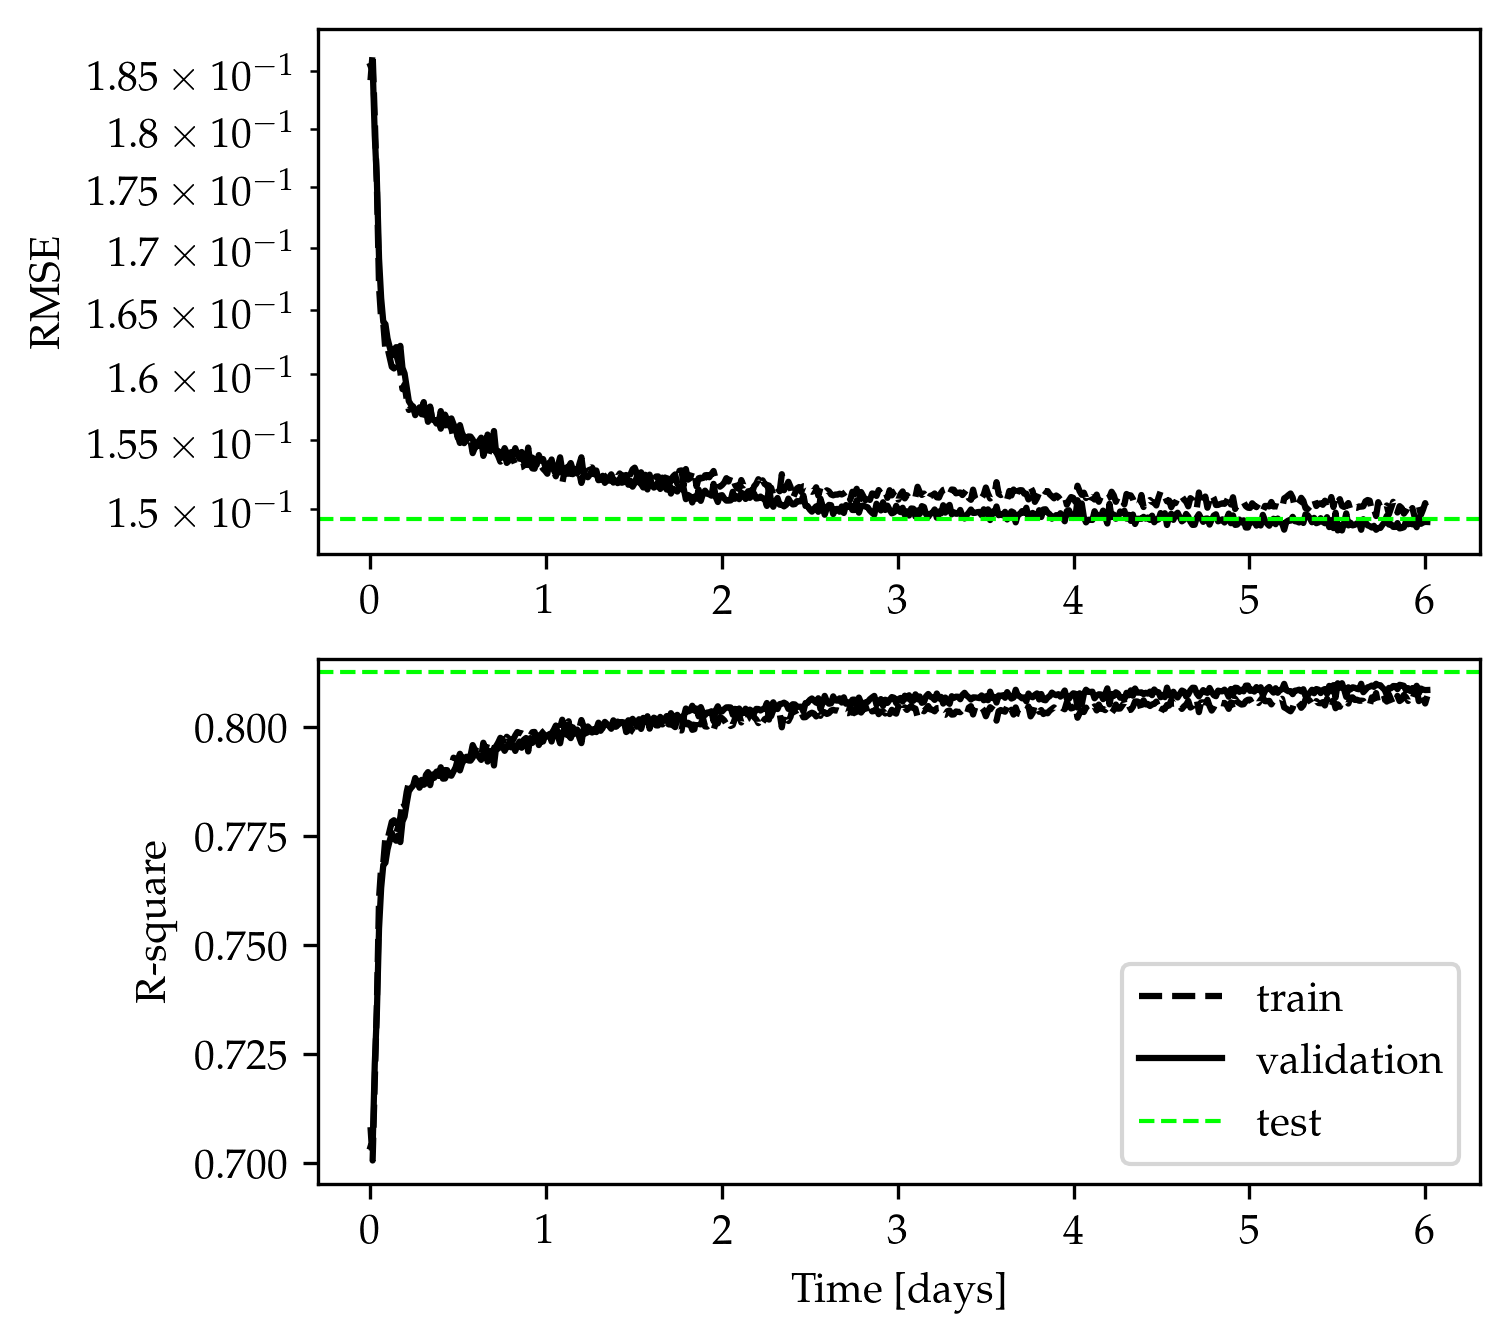

In [9]:
fig, axes = plt.subplots(2,1, figsize=(5,5), dpi=300)
for k, (metric, test_value) in enumerate(zip(['epoch_loss', 'epoch_r_square'], 
                               [loss, r2])):
    for ls, subset in zip(['--', '-'],['train', 'validation']):
        df = get_metrics(os.path.join(config['pretraining']['exp_path'], 'logs', subset),
                         show_keys=False, metric_name=metric, full_logs=True)
        df['time'] = ((df['wall_time'] - df['wall_time'].iloc[0])/3600)/24 
        axes[k].plot(df['time'], df['value'], color='k', linestyle=ls, label=subset)
    
    axes[k].axhline(y=test_value, color='lime', linestyle='--', linewidth=1, label='test')
    
    if k == 0:
        axes[k].set_yscale('log')
        axes[k].set_ylabel('RMSE')
    else:
        axes[k].set_ylabel('R-square')
        axes[k].set_xlabel('Time [days]')
        axes[k].legend()

## Finetuning results

Use `collect_metrics` to join all the metrics associated with the experiments in 
`./presentation/pipeline/config/<experiment>`

By default it gives **finetuning** metrics. Use `clasification=True` for getting classification metrics 

In [12]:
metrics_ft = collect_metrics(experiments_config_files, step='finetuning')

In [13]:
metrics_ft.groupby('case').mean()

,rmse,r_square
case,,
a,0.1094,0.757695
b,0.1094,0.757695


## Metrics by number of samples per class

Defining plot styles for the classifiers

In [14]:
styles = {'MLP+ATT':{'marker':'^', 'linestyle':'-'}, 
          'LSTM+ATT':{'marker':'o', 'linestyle':'--'}, 
          'Baseline':{'marker':'s', 'linestyle':':'}}

ft_names_changed = {
    'alcock': 'MACHO', 'atlas': 'ATLAS', 'ogle':'OGLE-III'
}

In [16]:
selected_metric = 'f1'

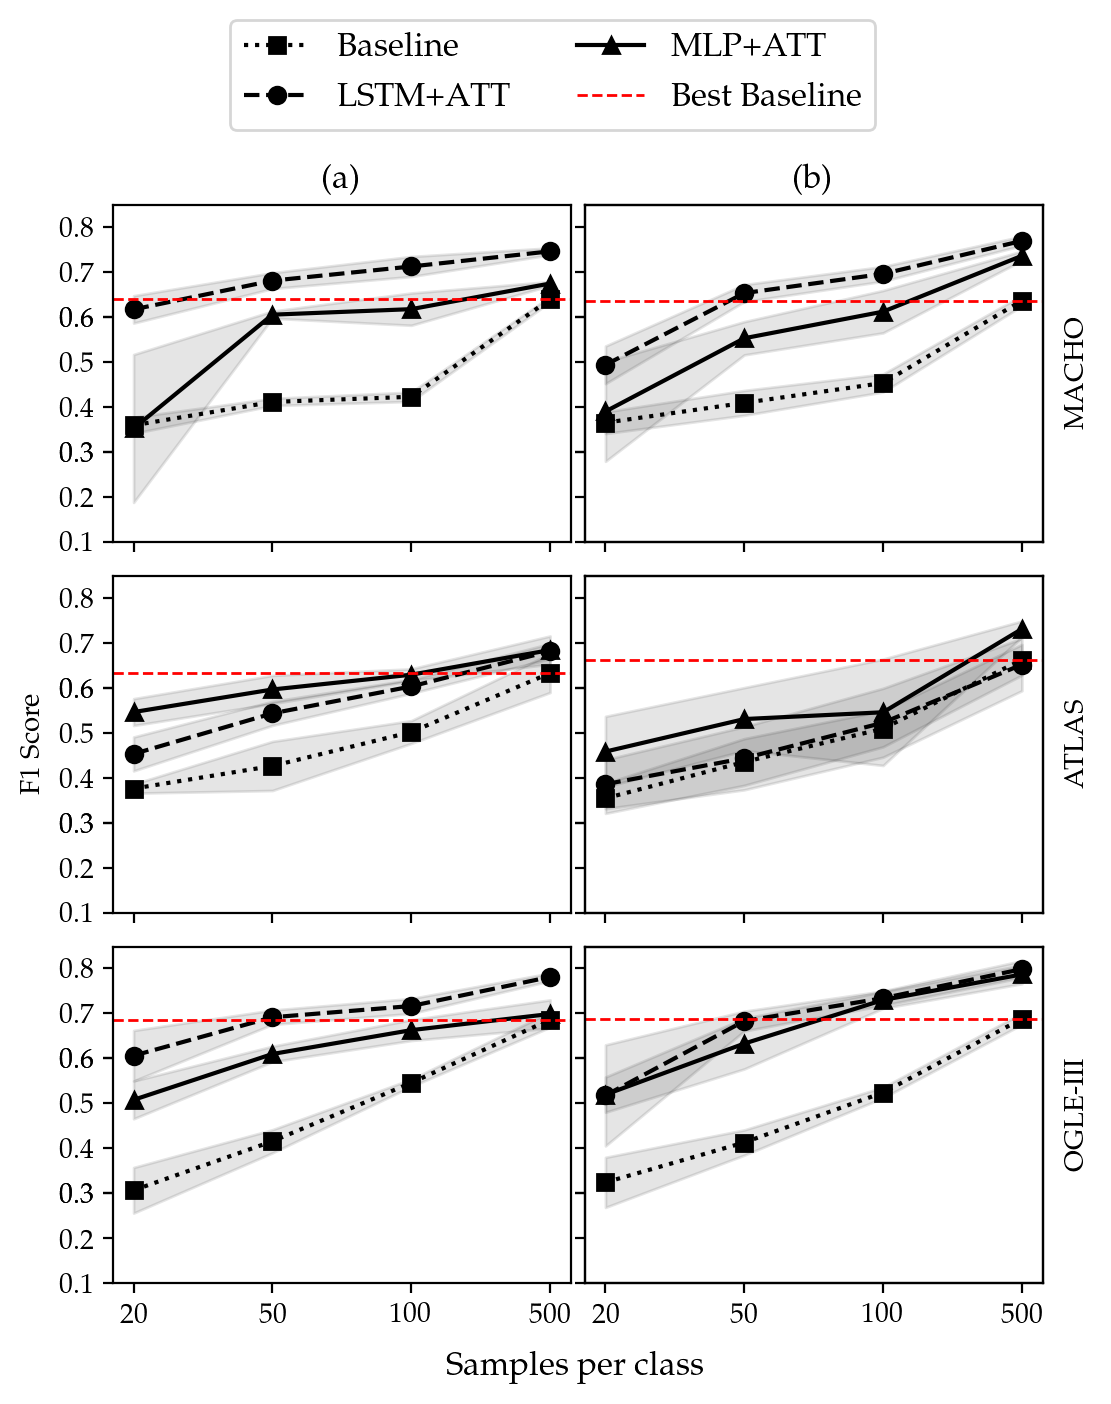

In [17]:
fig, axes = plt.subplots(3,2, figsize=(6,7), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03},
                         sharey=True, sharex=True, dpi=200)

for master_name in ['macho']:
    
    metrics = collect_metrics(experiments_config_files, step='classification', cases=['a', 'b'])
    metrics = metrics.replace({'mlp_att':'MLP+ATT', 'lstm_att':'LSTM+ATT', 'lstm':'Baseline'})
    
    
    for row, (dataset_name, frame_0) in enumerate(metrics.groupby('ft_data')):
        metrics_by_case = frame_0.groupby('case')
        for col, (sci_case, frame_1) in enumerate(metrics_by_case):

            metrics_by_model = frame_1.groupby('model')
            best_baseline = []
            for model_name, frame_2 in metrics_by_model:                    
                frame_2['spc'] = frame_2['file'].apply(lambda x: int(x.split('.')[1]))

                metrics_by_spc = frame_2.groupby('spc')
                model_metrics = []
                for spc, frame_3 in metrics_by_spc:
                    mean = frame_3[selected_metric].astype(float).mean()
                    std = frame_3[selected_metric].astype(float).std()
                    model_metrics.append((float(spc), mean, std))

                sorted_metrics = sorted(model_metrics, key=lambda tup: tup[0])
                sorted_metrics = np.vstack(sorted_metrics)
                
                x_range = range(len(sorted_metrics[:, 0]))
                axes[row][col].plot(x_range, 
                               sorted_metrics[:, 1], 
                               marker=styles[model_name]['marker'], 
                               color='k',
                               linestyle=styles[model_name]['linestyle'],
                               label=model_name)
                axes[row][col].fill_between(x_range, 
                                       sorted_metrics[:, 1]+sorted_metrics[:, 2], 
                                       sorted_metrics[:, 1]-sorted_metrics[:, 2],
                                       color='k', alpha=0.1)
                axes[row][col].set_xticks(x_range)
                axes[row][col].set_xticklabels([int(x) for x in sorted_metrics[:, 0]])
                
                if model_name == 'Baseline':
                    best_baseline.append(np.max(sorted_metrics[:, 1]))
                    
            if col == 1:
                ax2 = axes[row][col].twinx()     
                ax2.set_yticks([])
                ax2.set_ylabel(ft_names_changed[dataset_name])

            axes[row][col].axhline(y=np.max(best_baseline), 
                                   color='red', 
                                   linestyle='--', 
                                   linewidth=1, 
                                   label='Best Baseline')
            axes[row][col].set_yticks([round(x, 1) for x in np.linspace(0.1, 0.8, 10)])
            
axes[0][0].set_title('(a)')
axes[0][1].set_title('(b)')
axes[1][0].set_ylabel('F1 Score')
axes[0][0].legend(ncol=2, bbox_to_anchor = (1.7, 1.6), fontsize=12)
if selected_metric == 'acc':
    axes[0][0].set_ylabel('Accuracy', fontsize=12)


fig.text(0.51, 0.05, 'Samples per class', ha='center', va='center', fontsize=12)
plt.show()